In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


# import os
# import sys
# %cd /content/drive/MyDrive/CC/1115

Mounted at /content/drive
/content/drive/MyDrive/CC/1115


# CC's LSTM for stock prediction

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

2022-11-21 15:48:10.933513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 15:48:11.118211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 15:48:11.118236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 15:48:11.154997: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 15:48:11.971978: W tensorflow/stream_executor/platform/de

## Hyper parameters

In [2]:
# for dataset splitting
TRAIN_RATIO = 8
VALIDATION_RATIO = 1
TEST_RATIO = 1

# Using previous 60 days data to predict next days close price
## time window size
TIME_WINDOW_SIZE = 120
## feature size
NFEATURES = 33
## forescast size
FORECAST_SIZE = 1

# Model related parameters
BATCH_SIZE = 4 # for LSTM, don't use large batch_size
EPOCH = 100

# Train related parameters
MODEL_SAVED_PATH = "./saved_model/exp_new5/"
init_epoch = 0

## Load dataset from csv and split train, validation and test dataset (8:1:1)

In [3]:
dataset_df1 = pd.read_csv("./data/new_dataset.csv")

# dataset_df = dataset1.drop(columns={'Dividends','Stock Splits'})
# dataset_df

dataset_df = dataset_df1.drop(columns={'Dividends','Stock Splits','Unnamed: 0','Date'})
dataset_df = dataset_df.drop(columns={'AMZ_Volume','Apple_Volume','SP_Volume','GOOG_Volume','MS_Volume','ORC_Volume'})

In [4]:
dataset_df

,AMZ_Open,AMZ_High,AMZ_Low,AMZ_Close,Apple_Open,Apple_High,Apple_Low,Apple_Close,GOOG_Open,GOOG_High,...,SP_Close,VIX_Open,VIX_High,VIX_Low,VIX_Close,polarity,yhat,yhat_upper,yhat_lower,log_diff
0,8.794500,8.974000,8.777500,8.951500,12.540048,12.578776,12.472047,12.540048,16.262545,16.641375,...,1277.060059,22.950001,23.100000,22.540001,22.969999,0.0,6.808257,19.486105,-6.553545,0.000000
1,8.960500,9.025000,8.803500,8.875500,12.607435,12.645249,12.480581,12.607435,16.563665,16.693678,...,1277.300049,23.440001,23.730000,22.219999,22.219999,0.0,6.993756,21.862894,-7.391255,-0.008526
2,8.797000,8.912500,8.702500,8.880500,12.747405,12.763261,12.583957,12.747405,16.491436,16.537264,...,1281.060059,22.750000,23.090000,21.340000,21.480000,0.0,7.106478,20.389897,-6.713558,0.000563
3,8.903500,9.232500,8.875000,9.130500,12.880662,12.891335,12.783691,12.880662,16.417213,16.438385,...,1277.810059,21.240000,21.719999,20.580000,20.629999,0.0,7.017323,21.386000,-6.638345,0.027763
4,9.138000,9.218500,8.850000,8.928000,12.860233,13.043807,12.848645,12.860233,16.102144,16.114599,...,1280.699951,21.670000,21.780001,21.000000,21.070000,0.0,7.464025,22.195410,-7.301672,-0.022428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,171.037003,172.942993,169.215500,169.669495,179.586868,179.676494,176.340308,179.586868,147.463501,148.426498,...,4791.189941,19.370001,19.410000,17.549999,17.680000,0.0,187.237354,200.869817,172.641770,-0.008212
2513,170.182495,172.175995,169.135498,170.660995,178.551132,180.582734,177.794270,178.551132,148.374496,148.374496,...,4786.350098,17.780001,18.469999,17.510000,17.540001,0.0,187.634934,201.744047,173.763224,0.005827
2514,170.839996,171.212006,168.600494,169.201004,178.640778,179.885626,177.405882,178.640778,146.429504,147.183746,...,4793.060059,17.629999,18.000000,16.709999,16.950001,0.0,187.899439,200.904501,173.503755,-0.008592
2515,169.699997,170.888000,168.524002,168.644501,177.465637,179.825881,177.356090,177.465637,146.449997,147.062500,...,4778.729980,17.299999,17.790001,16.620001,17.330000,0.0,188.099826,202.519201,175.793765,-0.003294


In [5]:
# transfer pandas dataframe to numpy ndarray
dataset_np = np.array(dataset_df.iloc[:, 0:])
dataset_np.shape

(2517, 33)

In [6]:
# dataset_df = dataset_df.drop(columns=['Unnamed: 0', 'Date'])
# dataset_df

In [7]:
# split train, validation and test
dataset_size = dataset_np.shape[0]
dataset_segment = dataset_size // 10
train_dataset = dataset_np[:TRAIN_RATIO * dataset_segment]
validation_dataset = dataset_np[TRAIN_RATIO * dataset_segment: (TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment]
test_dataset = dataset_np[(TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment:]

train_dataset.shape, validation_dataset.shape, test_dataset.shape

((2008, 33), (251, 33), (258, 33))

### save dataset to file

In [8]:
dataset_pickle_folder = "./data/pickles"
train_set_filename = "train_set.pk"
valid_set_filename = "valid_set.pk"
test_set_filename = "test_set.pk"

train_set_path = os.path.join(dataset_pickle_folder, train_set_filename)
valid_set_path = os.path.join(dataset_pickle_folder, valid_set_filename)
test_set_path = os.path.join(dataset_pickle_folder, test_set_filename)

with open(train_set_path, "wb") as fp:
    pickle.dump(train_dataset, fp)

with open(valid_set_path, "wb") as fp:
    pickle.dump(validation_dataset, fp)

with open(test_set_path, "wb") as fp:
    pickle.dump(test_dataset, fp)

print("Done")

Done


### load dataset from file (starts here)

In [9]:
dataset_pickle_folder = "./data/pickles"
train_set_filename = "train_set.pk"
valid_set_filename = "valid_set.pk"
test_set_filename = "test_set.pk"

train_set_path = os.path.join(dataset_pickle_folder, train_set_filename)
valid_set_path = os.path.join(dataset_pickle_folder, valid_set_filename)
test_set_path = os.path.join(dataset_pickle_folder, test_set_filename)

with open(train_set_path, "rb") as fp:
    train_dataset = pickle.load(fp)

with open(valid_set_path, "rb") as fp:
    validation_dataset = pickle.load(fp)

with open(test_set_path, "rb") as fp:
    test_dataset = pickle.load(fp)

train_dataset.shape, validation_dataset.shape, test_dataset.shape

((2008, 33), (251, 33), (258, 33))

## Define data normalization function

In [10]:
def normalize_by_column_within_time_window(x, y):
  # x.shape = (window_size, 40)
  # y.shape = (forecast_size)
    EPS = 1e-5
    ret_x = np.array(x)
    ret_y = np.array(y)

    train_close_price_min = np.min(ret_x[:, 3]) # the 3rd column of x is the AMZN close price
    train_close_price_max = np.max(ret_x[:, 3])

    for i in range(ret_x.shape[1]):
        column_min = np.min(ret_x[:, i])
        column_max = np.max(ret_x[:, i])
#     print("debug:", i, column_min, column_max)
        ret_x[:, i] = (ret_x[:, i] - column_min) / (column_max - column_min + EPS)  # EPS for value stability (x / 0.000000000000000001 will be huge)

  
    ret_y = (ret_y - train_close_price_min) / (train_close_price_max - train_close_price_min + EPS)
  
    return ret_x, ret_y

In [ ]:
# # fix every column into [0, 1)
# train_data_norm = normalize_by_column(train_dataset)
# validation_dataset_norm = normalize_by_column(validation_dataset)
# test_dataset_norm = normalize_by_column(test_dataset)

In [ ]:
# np.min(train_data_norm[:, 0]), np.max(train_data_norm[:, 0])

## Define Kears data generator (keras.utils.Sequence)

In [11]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataset, batch_size, window_size, forecast_size, shuffle=False, normalization=True):
    self.dataset = dataset  # shape = (n, features)
    self.batch_size = batch_size
    self.window_size = window_size
    self.forecast_size = forecast_size

    self.x = []             # final x.shape = (-1, window_size, features)
    self.y = []             # final y.shape = (-1, forecast_size)
    for i in range(self.dataset.shape[0] - window_size - forecast_size):
      # cur_x: dataset[i: i + window_size], shape = (window_size, nfeatures)
      # cur_y: dataset[i + window_size: i + window_size + forecast_size, 3], shape = shape = (window_size, 1)
      # normalize_by_column_within_time_window fix x and y to around [0, 1]
      if normalization: 
        cur_x, cur_y = normalize_by_column_within_time_window(dataset[i: i + window_size, :], dataset[i + window_size: i + window_size + forecast_size, 3].reshape(-1, forecast_size))
      else:
        cur_x = dataset[i: i + window_size, :]
        cur_y = dataset[i + window_size: i + window_size + forecast_size, 3].reshape(-1, forecast_size)

      self.x.append(cur_x)
      self.y.append(cur_y)
      
    self.x = np.array(self.x)
    self.y = np.array(self.y).reshape(-1, forecast_size)
    
    if shuffle:
      shuffle_idx = np.random.permutation(self.x.shape[0])
      self.x = self.x[shuffle_idx, :, :]
      self.y = self.y[shuffle_idx, :]

  def __len__(self):
    return self.x.shape[0] // self.batch_size

  def __getitem__(self, idx):
    # return one batch data 
    # x: (batch_size, window_size, features)
    # y: (batch_size, forecast_size, 1)
    batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]

    return batch_x, batch_y

In [12]:
train_gen = DataGenerator(dataset=train_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=True)
valid_gen = DataGenerator(dataset=validation_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False)

# test generator does not need normalization... since it's not used in training
# but it only used in the inference process
# to easily draw the figures, just set batch_size as 1 and normalization as false
test_gen = DataGenerator(dataset=test_dataset, batch_size=1, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False, normalization=False)

In [13]:
train_batch_x, train_batch_y = train_gen[0]
train_batch_x.shape, train_batch_y.shape
# should be (batch, window_size, nfeatures) and (batch, forecast_size)

((4, 120, 33), (4, 1))

In [14]:
train_batch_y[0]

array([0.11084717])

## Define sequential model and train related stuff

In [20]:
class LSTMPredictor(keras.Model):

  def __init__(self, input_shape, forecast_size): 
    # input shape should be (batch, window_size, features)
    super().__init__()

    self.lstm1 = keras.layers.LSTM(150, activation="sigmoid", input_shape=input_shape, return_sequences=True)  # (batch, window_size, 10)
    self.dropout1 = keras.layers.Dropout(0.1)

#     self.lstm2 = keras.layers.LSTM(100, activation="sigmoid", return_sequences=False) # (batch, window_size, 32)
#     self.dropout2 = keras.layers.Dropout(0.1)

    self.dense5 = keras.layers.Dense(forecast_size) # (batch, forecast_size)
  
  def call(self, inputs):
    x = self.lstm1(inputs)
    x = self.dropout1(x)
#     x = self.lstm2(x)
#     x = self.dropout2(x)

    x = self.dense5(x)
    return x

In [21]:
model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

model.compile(optimizer=adam, loss="mse", metrics=["mape"])
model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))
model.summary()

Model: "lstm_predictor_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               multiple                  110400    
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  151       
                                                                 
Total params: 110,551
Trainable params: 110,551
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [23]:
# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=MODEL_SAVED_PATH + 'LSTM_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=MODEL_SAVED_PATH + 'LSTM_training_log.csv',
                       separator=',',
                       append=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             reduce_lr,
             terminate_on_nan]

## Train

In [24]:
history = model.fit(train_gen, 
                    epochs=EPOCH,
                    validation_data=valid_gen,
                    callbacks=callbacks,
                    initial_epoch=init_epoch);

Epoch 1/100
471/471 [==============================] - ETA: 0s - loss: 0.1134 - mape: 160.8022
Epoch 1: val_loss improved from inf to 0.03384, saving model to ./saved_model/exp_new5/LSTM_epoch-01_loss-0.1134_val_loss-0.0338.h5
471/471 [==============================] - 34s 69ms/step - loss: 0.1134 - mape: 160.8022 - val_loss: 0.0338 - val_mape: 20.1778 - lr: 0.0010
Epoch 2/100
471/471 [==============================] - ETA: 0s - loss: 0.0881 - mape: 160.4249
Epoch 2: val_loss did not improve from 0.03384
471/471 [==============================] - 33s 70ms/step - loss: 0.0881 - mape: 160.4249 - val_loss: 0.0469 - val_mape: 21.1254 - lr: 0.0010
Epoch 3/100
471/471 [==============================] - ETA: 0s - loss: 0.0823 - mape: 157.6997
Epoch 3: val_loss did not improve from 0.03384
471/471 [==============================] - 32s 69ms/step - loss: 0.0823 - mape: 157.6997 - val_loss: 0.0387 - val_mape: 22.4134 - lr: 0.0010
Epoch 4/100
471/471 [==============================] - ETA: 0s - l

KeyboardInterrupt: 

## Inference

In [25]:
# load model
model_name = "LSTM_epoch-03_loss-0.0825_val_loss-0.0493.h5"
weight_path = os.path.join(MODEL_SAVED_PATH, model_name)
pred_model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)
pred_model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))

pred_model.load_weights(weight_path)

ValueError: Cannot assign value to variable ' lstm_2/lstm_cell_2/kernel:0': Shape mismatch.The variable shape (33, 600), and the assigned value shape (33, 200) are incompatible.

In [27]:
def inference(model, test_data, verbose=False):
  # test_data should be (window_size, 40)
    test_data_tmp = np.copy(test_data)
    EPS = 1e-5
    close_price_min = np.min(test_data_tmp[:, 3]) # the 3rd column of x is the close price
    close_price_max = np.max(test_data_tmp[:, 3]) # the 3rd column of x is the close price
    for i in range(test_data.shape[1]):
        column_min = np.min(test_data_tmp[:, i])
        column_max = np.max(test_data_tmp[:, i])
        test_data_tmp[:, i] = (test_data_tmp[:, i] - column_min) / (column_max - column_min + EPS)

    y_pred = model.predict(test_data_tmp.reshape(1, test_data_tmp.shape[0], test_data_tmp.shape[1]), verbose = verbose)
    y_pred = y_pred * (close_price_max - close_price_min + EPS) + close_price_min
    return y_pred.reshape(-1)

In [28]:
def draw_inference(model, test_data, test_label):
  # test_data, test_label = test_gen[idx]
    y_history = test_data[:, 3] # the 3rd cloumn is the close price
    y_pred = inference(model, test_data)

    x_idxs = np.arange(test_data.shape[0] + test_label.shape[0], dtype=np.int32)

    plt.scatter(x_idxs[:test_data.shape[0]], y_history, marker="*")
    plt.plot(x_idxs[:test_data.shape[0]], y_history)

    plt.scatter(x_idxs[test_data.shape[0]: ], test_label, marker="D")
    plt.plot(x_idxs[test_data.shape[0]: ], test_label)

    plt.scatter(x_idxs[test_data.shape[0]: ], y_pred, marker="+")
    plt.plot(x_idxs[test_data.shape[0]: ], y_pred)

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [32]:
def draw_test_dataset(model, test_ds, window_size=60, y_column=3):
    history_prices = test_ds[:, y_column]
    history_index = np.arange(test_ds.shape[0])
    pred_prices = list()
    true_prices = list()
    pred_index = np.arange(window_size, test_ds.shape[0] - 1)

    pred_cnt = 0
    apes = list()

    for i in range(0, test_ds.shape[0] - window_size - 1): 
        cur_x = test_ds[i: i + window_size]
        pred_y = inference(model, cur_x)
        label_y = test_ds[i+window_size + 1, y_column]

        apes.append(np.abs(label_y - pred_y) / label_y)
        pred_prices.append(pred_y)
        true_prices.append(label_y)
  
    apes = np.array(apes)
    mape = np.mean(apes)

    plt.title("Predicted Price & Actual Price", fontsize=20)
    plt.rcParams["figure.figsize"] = (40,20)
    pred_prices = np.array(pred_prices)
    true_prices = np.array(true_prices)
    plt.plot(history_index, history_prices)
    plt.scatter(history_index, history_prices, marker="o")
    plt.plot(pred_index, pred_prices)
    plt.scatter(pred_index, pred_prices, marker="+")

    return pred_prices, true_prices
    

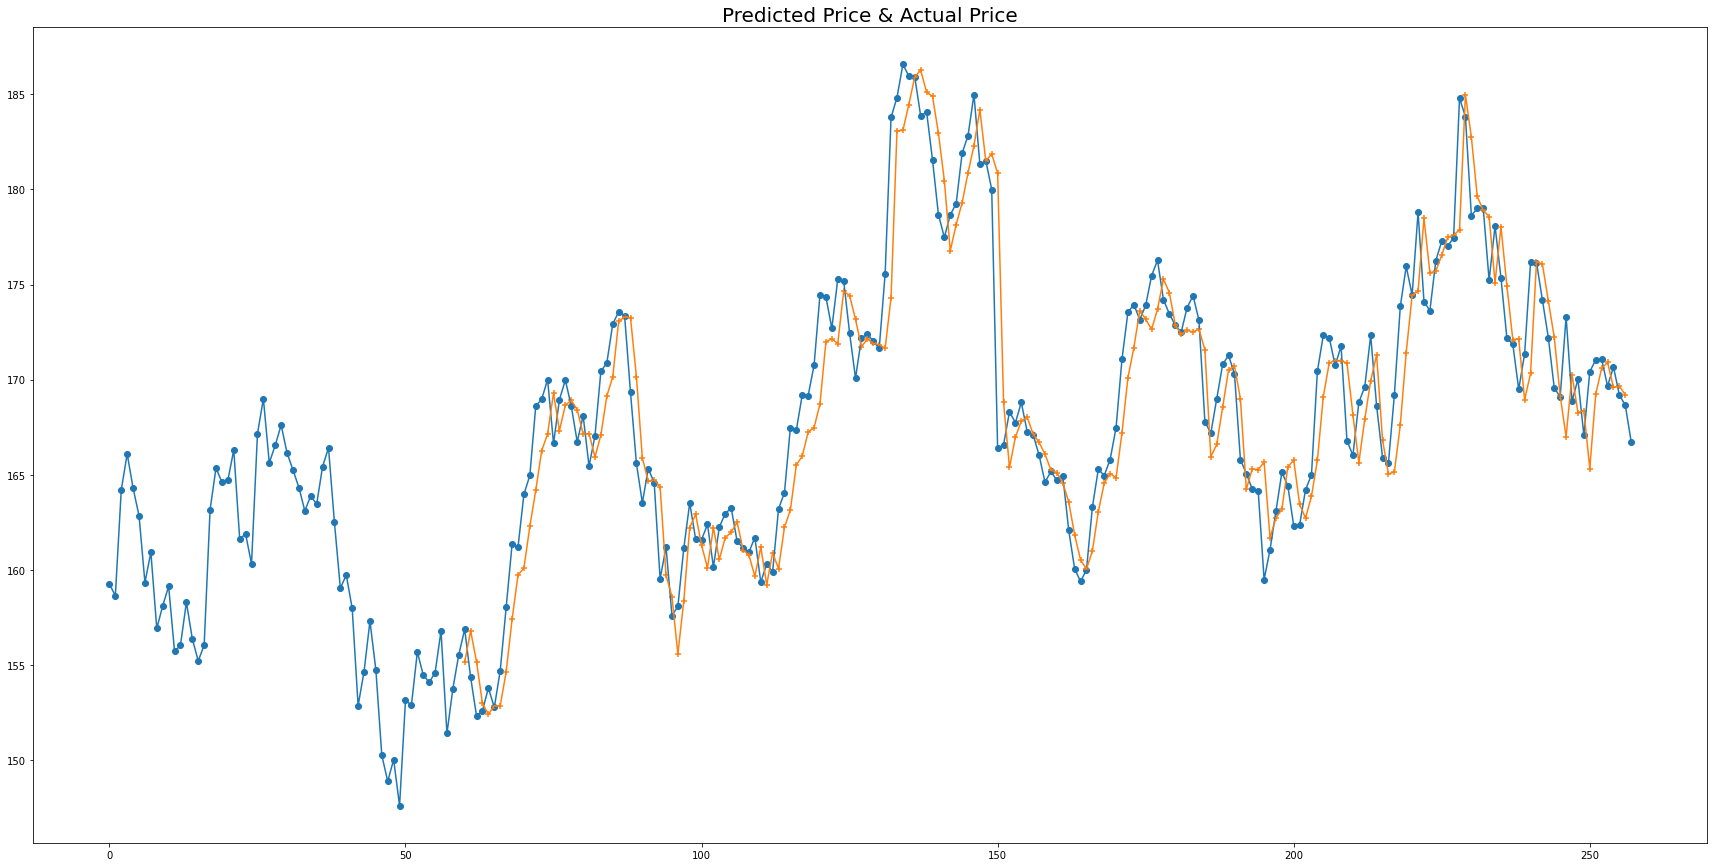

In [33]:
pred_prices, true_prices = draw_test_dataset(pred_model, test_dataset)

In [34]:
pred_prices.shape, true_prices.shape

((197, 1), (197,))

In [35]:
def performance_metrics(y_true, y_pred):    
    
    return r2_score(y_true,y_pred), mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred)
    
    

In [36]:
performance_metrics(true_prices, pred_prices)

(0.7025439517423783, 2.916094939720813, 14.83454261108912)